## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_response = pd.read_csv('/content/drive/MyDrive/NIDA/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/NIDA/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [7]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [8]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [9]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [10]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU เป็นลูกค้ามานานขนาดไหน

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv['CLV'] = df_clv['monetary_value'] / df_clv['AOU']
df_clv['Time frequency'] = df_clv['AOU'] / (df_clv['recency']/30)
df_clv['CLV_Ticket_size'] = df_clv['CLV']*df_clv['ticket_size']
df_clv['SD_ticket_size'] = ((df_clv['ticket_size']-df_clv['ticket_size'].mean())**2)/df_clv['ticket_size']

In [11]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,CLV,Time frequency,CLV_Ticket_size,SD_ticket_size
0,CS1112,62.0,15,1012,1309,67.466667,0.773109,633.387097,52.159104,0.284368
1,CS1113,36.0,20,1490,1354,74.500000,1.100443,1128.333333,81.983013,1.748545
2,CS1114,33.0,19,1432,1309,75.368421,1.093965,1190.000000,82.450404,2.001423
3,CS1115,12.0,22,1659,1303,75.409091,1.273216,3257.500000,96.012035,2.013613
4,CS1116,204.0,13,857,1155,65.923077,0.741991,169.852941,48.914352,0.122049


## **Calculating response rate**

In [12]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


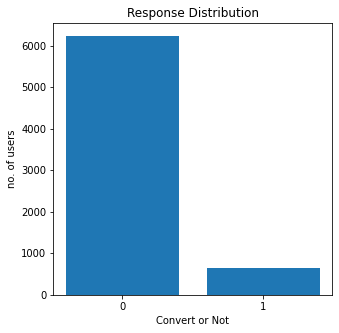

In [13]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [14]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [15]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,CLV,Time frequency,CLV_Ticket_size,SD_ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667,0.773109,633.387097,52.159104,0.284368
1,CS1113,0,36.0,20,1490,1354,74.500000,1.100443,1128.333333,81.983013,1.748545
2,CS1114,1,33.0,19,1432,1309,75.368421,1.093965,1190.000000,82.450404,2.001423
3,CS1115,1,12.0,22,1659,1303,75.409091,1.273216,3257.500000,96.012035,2.013613
4,CS1116,1,204.0,13,857,1155,65.923077,0.741991,169.852941,48.914352,0.122049


## **Creating train and test dataset**

In [16]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [17]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.2, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.2, random_state=0)

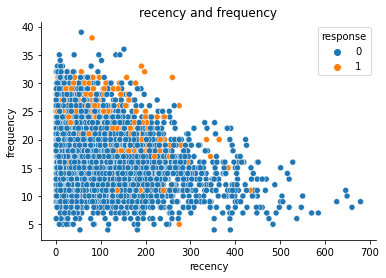

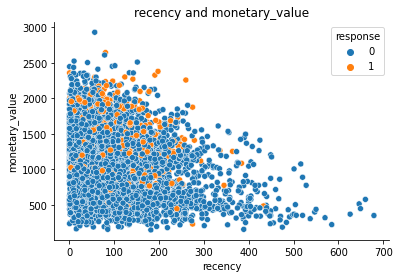

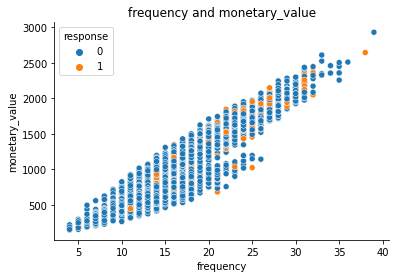

In [18]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

In [19]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size','CLV','CLV_Ticket_size','Time frequency']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size','CLV','CLV_Ticket_size','Time frequency']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()


Output hidden; open in https://colab.research.google.com to view.

## **Fixing imbalanced with SMOTE**

In [20]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [21]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      4997
           1       0.65      0.72      0.68      4997

    accuracy                           0.66      9994
   macro avg       0.67      0.66      0.66      9994
weighted avg       0.67      0.66      0.66      9994

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1240
           1       0.17      0.71      0.27       137

    accuracy                           0.62      1377
   macro avg       0.56      0.66      0.51      1377
weighted avg       0.87      0.62      0.70      1377



In [22]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      4997
           1       0.67      0.73      0.70      4997

    accuracy                           0.68      9994
   macro avg       0.68      0.68      0.68      9994
weighted avg       0.68      0.68      0.68      9994

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1240
           1       0.17      0.69      0.27       137

    accuracy                           0.63      1377
   macro avg       0.56      0.66      0.51      1377
weighted avg       0.87      0.63      0.71      1377



## **XGBoost**

In [23]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm, y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.564239
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.716453
[2]	validation_0-auc:0.689345
[3]	validation_0-auc:0.677478
[4]	validation_0-auc:0.704385
[5]	validation_0-auc:0.715629
[6]	validation_0-auc:0.705486
Stopping. Best iteration:
[1]	validation_0-auc:0.716453

training set
              precision    recall  f1-score   support

           0       0.70      0.63      0.67      4997
           1       0.67      0.74      0.70      4997

    accuracy                           0.68      9994
   macro avg       0.69      0.68      0.68      9994
weighted avg       0.69      0.68      0.68      9994

test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1240
           1       0.17      0.69      0.28       137

    accuracy                           0.64      1377
   macro avg       0.56      0.67      0.52      1377
weighted avg       0.87

In [24]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.713922
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.728976
[2]	validation_0-auc:0.722972
[3]	validation_0-auc:0.725721
[4]	validation_0-auc:0.729747
[5]	validation_0-auc:0.73086
[6]	validation_0-auc:0.73086
[7]	validation_0-auc:0.7329
[8]	validation_0-auc:0.732302
[9]	validation_0-auc:0.732037
[10]	validation_0-auc:0.730489
[11]	validation_0-auc:0.728629
[12]	validation_0-auc:0.72897
Stopping. Best iteration:
[7]	validation_0-auc:0.7329

training set
              precision    recall  f1-score   support

           0       0.75      0.54      0.63      4997
           1       0.64      0.82      0.72      4997

    accuracy                           0.68      9994
   macro avg       0.69      0.68      0.67      9994
weighted avg       0.69      0.68      0.67      9994

test set
              precision    recall  f1-score   support

           0       0.97      0.53      0.68      1240
          

In [25]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [27]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 500],
    'clf__learning_rate': [0.005, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5) # , random_state=42 ?
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [28]:
xgb_model_clv_GS.best_score_

0.7319690329516507

In [29]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7319690329516507
[[755 485]
 [ 37 100]]
test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1240
           1       0.17      0.73      0.28       137

    accuracy                           0.62      1377
   macro avg       0.56      0.67      0.51      1377
weighted avg       0.88      0.62      0.70      1377



In [30]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.005, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7fdb570b45f0>}
